In [17]:
import numpy as np
from keras.datasets import cifar10
from keras import models, layers, optimizers, Input, Model
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split 

In [18]:
def PlotGraph(history):
    import matplotlib.pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(acc) + 1)
    plt.plot(epochs,acc,'b',label='training accuracy')
    plt.plot(epochs,val_acc,'r',label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs,loss,'b',label='training loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [19]:
# Loading
EPOCHS = 80
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [20]:
# Pre-processing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
# Normalizing
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
X_test = X_test.astype('float32')/255
y_test =  y_test.astype('float32')
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
dropout_16 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
dropout_17 (Dropout)         (None, 13, 13, 64)        0   

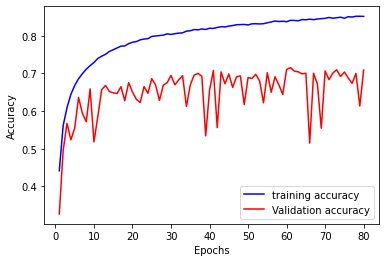

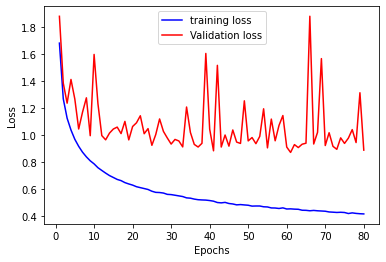

<Figure size 432x288 with 0 Axes>

In [21]:
#Model using no block
input_tensor = Input(shape=(32,32,3))
convo_1 = layers.Conv2D(32,3,activation='relu')(input_tensor)
convo_1 = layers.Dropout(0.2)(convo_1)
convo_1 = layers.BatchNormalization()(convo_1)
convo_1 = layers.MaxPooling2D(2)(convo_1)

convo2 = layers.Conv2D(64,3,activation='relu')(convo_1)
convo2 = layers.Dropout(0.2)(convo2)
convo2 = layers.BatchNormalization()(convo2)
convo2 = layers.MaxPooling2D(2)(convo2)

output = layers.Flatten()(convo2)
output_class = layers.Dense(10,activation='softmax')(output)
model1 = Model(input_tensor,output_class)
model1.summary()

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
history1 = model1.fit(X_train,y_train_encoded,batch_size=128,epochs=EPOCHS,validation_data=(X_val,y_val_encoded))
PlotGraph(history1)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 30, 30, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 30, 30, 32)   0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 30, 30, 32)   128         dropout_18[0][0]                 
____________________________________________________________________________________________

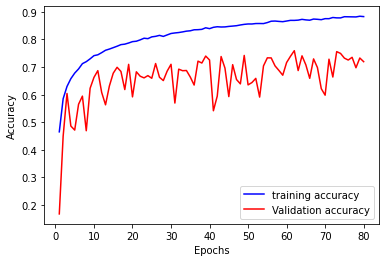

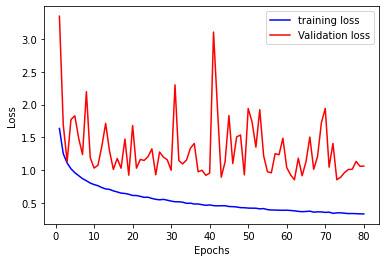

<Figure size 432x288 with 0 Axes>

In [22]:
#Model Using inception block
input_tensor = Input(shape=(32,32,3))
convo_1 = layers.Conv2D(32,3,activation='relu')(input_tensor)
convo_1 = layers.Dropout(0.2)(convo_1)
convo_1 = layers.BatchNormalization()(convo_1)
convo_1 = layers.MaxPooling2D(2)(convo_1)

convo2 = layers.Conv2D(64,3,activation='relu')(convo_1)
convo2 = layers.Dropout(0.2)(convo2)
convo2 = layers.BatchNormalization()(convo2)
convo2 = layers.MaxPooling2D(2)(convo2)
#inception block
branch1 = layers.Conv2D(32,1,activation='relu',padding='same')(convo2)
branch1 = layers.Dropout(0.2)(branch1)
branch1 = layers.BatchNormalization()(branch1)

branch2 = layers.Conv2D(32,1,activation='relu',padding='same')(convo2)
branch2 = layers.Conv2D(32,3,activation='relu',padding='same')(branch2)
branch2 = layers.Dropout(0.2)(branch2)
branch2 = layers.BatchNormalization()(branch2)

branch3 = layers.MaxPooling2D(3, strides=1,padding='same')(convo2)
branch3 = layers.Conv2D(32,1,activation='relu',padding='same')(branch3)
branch3 = layers.Dropout(0.2)(branch3)
branch3 = layers.BatchNormalization()(branch3)

branch4 = layers.Conv2D(32,1,activation='relu',padding='same')(convo2)
branch4 = layers.Conv2D(32,5,activation='relu',padding='same')(branch4)
branch4 = layers.Dropout(0.2)(branch4)
branch4 = layers.BatchNormalization()(branch4)

output_inception = layers.concatenate([branch1,branch2,branch3,branch4],axis=-1)
output_inception = layers.Flatten()(output_inception)
output_inception = layers.Dropout(0.2)(output_inception)
output_inception = layers.BatchNormalization()(output_inception)
output_class = layers.Dense(10,activation='softmax')(output_inception)
model2 = Model(input_tensor,output_class)
model2.summary()

model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
history2 = model2.fit(X_train,y_train_encoded,batch_size=128,epochs=EPOCHS,validation_data=(X_val,y_val_encoded))
PlotGraph(history2)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 32)   896         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 16, 16, 32)   0           max_pooling2d_12[0][0]           
____________________________________________________________________________________________

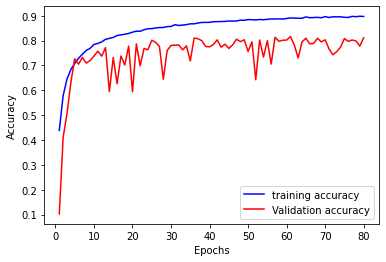

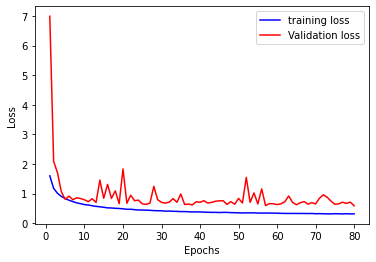

<Figure size 432x288 with 0 Axes>

In [23]:
# Using residual block
input_tensor = Input(shape=(32,32,3))
block1 = layers.Conv2D(32,3,activation='relu',padding='same')(input_tensor)
block1 = layers.MaxPooling2D(2)(block1)
block1 = layers.Dropout(0.2)(block1)
block1 = layers.BatchNormalization()(block1)

block2 = layers.Conv2D(32,3,activation='relu',padding='same')(block1)
block2 = layers.Dropout(0.2)(block2)
block2 = layers.BatchNormalization()(block2)

rest1 = layers.add([block2,block1])

block3 = layers.Conv2D(64,3,activation='relu',padding='same')(rest1)
block3 = layers.MaxPooling2D(2)(block3)
block3 = layers.Dropout(0.2)(block3)
block3 = layers.BatchNormalization()(block3)

block4 = layers.Conv2D(64,3,activation='relu',padding='same')(block3)
block4 = layers.Dropout(0.2)(block4)
block4 = layers.BatchNormalization()(block4)

rest2 = layers.add([block4,block3])

block5 = layers.Conv2D(64,3,activation='relu',padding='same')(rest2)
block5 = layers.Dropout(0.2)(block5)
block5 = layers.BatchNormalization()(block5)

block5 = layers.Flatten()(block5)
block5 = layers.Dropout(0.2)(block5)
output_dense = layers.Dense(128,activation='relu')(block5)
output_dense = layers.Dropout(0.2)(output_dense)
output_dense = layers.BatchNormalization()(output_dense)
output = layers.Dense(10,activation='softmax')(output_dense)
model3 = Model(input_tensor,output)
model3.summary()
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
history3 = model3.fit(X_train,y_train_encoded,batch_size=128,epochs=EPOCHS,validation_data=(X_val,y_val_encoded))
PlotGraph(history3)

In [28]:
import pandas as pd
df = pd.DataFrame()
df["No block"] = history1.history["val_acc"]
df["Inception"] = history2.history["val_acc"]
df["Residual"] = history3.history["val_acc"]
arr= []
for i in range(EPOCHS-1):
    if i % 5 != 0:
      arr.append(i)
df = df.drop(arr)
df = df.style.highlight_max(color = 'lightgreen', axis = 1)
df

,No block,Inception,Residual
0,0.326900,0.168000,0.102700
5,0.636200,0.565200,0.705300
10,0.585600,0.687000,0.757500
15,0.646600,0.699100,0.626600
20,0.631200,0.682800,0.786900
25,0.668900,0.712800,0.793300
30,0.669500,0.569600,0.781600
35,0.695400,0.634800,0.810500
40,0.707500,0.541700,0.784200
45,0.662600,0.708700,0.783000


In [29]:
test_loss1, test_acc1 = model1.evaluate(X_test,y_test_encoded)
test_loss2, test_acc2 = model2.evaluate(X_test,y_test_encoded)
test_loss3, test_acc3 = model3.evaluate(X_test,y_test_encoded)
print("Test acc for model1: {}%".format(test_acc1))
print("Test acc for model2: {}%".format(test_acc2))
print("Test acc for model3: {}%".format(test_acc3))

313/313 [==============================] - 1s 3ms/step - loss: 0.6088 - acc: 0.8039
Test acc for model1: 0.7106999754905701%
Test acc for model2: 0.7214000225067139%
Test acc for model3: 0.8039000034332275%
